# SQUEEZENET

In [1]:
from tqdm import tqdm
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from random import uniform
import bcolz
from time import *
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers import Input, Dense
import math
import pandas as pd
from keras.utils import np_utils as u
import utils; reload(utils)
from utils import *
import resnet50; reload(resnet50)
from resnet50 import Resnet50
from keras.preprocessing.image import ImageDataGenerator
import myFunctionsv3; reload(myFunctionsv3)
from myFunctionsv3 import *
from  keras.applications.resnet50 import ResNet50
from squeezenet import SqueezeNet

import gc

%matplotlib inline


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


# Training

In [2]:
nf=128; p=0.01
def get_lrg_layers():
    
    inp = Input((21, 39, 512))
    x = BatchNormalization(axis=1)(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(nf,(1,1), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(nf,(1,1), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    x = Conv2D(nf,(1,1), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    x = Conv2D(nf,(3,3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=1)(x)
    
    x_15 = Conv2D(15,(3,3), activation='relu', padding='same')(x)
    x_15 = BatchNormalization(axis=1)(x_15)
    x_15 = GlobalMaxPooling2D()(x_15)
    x_sig_15 = Activation('sigmoid')(x_15)
    
    x_4 = Conv2D(4,(3,3), activation='relu', padding='same')(x)
    x_4 = BatchNormalization(axis=1)(x_4)
    x_4 = GlobalMaxPooling2D()(x_4)
    x_sof_4 = Activation('sigmoid')(x_4)
    
    x_2 = Conv2D(3,(3,3), activation='relu', padding='same')(x)
    x_2 = BatchNormalization(axis=1)(x_2)
    x_2 = GlobalMaxPooling2D()(x_2)
    x_sof_2 = Activation('softmax')(x_2)
    
    model = Model([inp], [x_sig_15, x_sof_4, x_sof_2])
    
    return model

In [3]:
lrg_model = get_lrg_layers()

In [4]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 21, 39, 512)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 21, 39, 512)   84          input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 10, 19, 512)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 19, 128)   65664       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [5]:
gc.collect()

27062

In [6]:
def addZeroLabelCannula(y):
    temp = sum(np.transpose(y)[[1,2,3,4],:]) 
    temp[temp>1]=1
    temp = 1 - temp 
    final = np.hstack((y[:,[1,2,3,4]],np.expand_dims(temp,1)))
    return final

In [7]:
def addZeroLabelForceps(y):
    temp = sum(np.transpose(y)[[7,8],:]) 
    temp[temp>1]=1
    temp = 1 - temp 
    final = np.hstack((y[:,[7,8]],np.expand_dims(temp,1)))
    return final

In [8]:
def feature_generator(files):
    while 1:
        for i in range(len(files)):
            conv_trn_feat = load_array('/cat/home/ubuntu/cat/out/features/train/'+files[i]+'_sqznt.dat')
            label = load_array('/cat/home/ubuntu/cat/in/train/folds/'+files[i]+'_labels.dat')
            totalFrames = label.shape[0]
            batches = int(totalFrames/batch_size)
            for j in range(batches):
                x = conv_trn_feat[j*batch_size:(j+1)*batch_size,]
                y = label[j*batch_size:(j+1)*batch_size,2:23]
                
                y1 = y[:,[0,5,6,9,10,11,12,13,14,15,16,17,18,19,20]] #remaining
                
                #y2 = addZeroLabelCannula(y)
                y2 = y[:,[1,2,3,4]]
                #Charleux canula, hydrodissection canula, Rycroft canula, viscoelastic cannula
                
                y3 = addZeroLabelForceps(y)
                #Bonn forceps, capsulorhexis forceps
                
                yield (x, [y1,y2,y3])
            del(conv_trn_feat,label)
            gc.collect()

In [9]:
def feature_generator_val(files):
    while 1:
        for i in range(len(files)):
            conv_val_feat = load_array('/cat/home/ubuntu/cat/out/features/train/'+files[i]+'_sqznt.dat')
            label_val = load_array('/cat/home/ubuntu/cat/in/train/labels/'+files[i]+'_labels.dat')
            totalFrames = label_val.shape[0]
            batches = int(totalFrames/batch_size)
            for j in range(batches): 
                x = conv_val_feat[j*batch_size:(j+1)*batch_size,]
                y = label_val[j*batch_size:(j+1)*batch_size,2:23]
                
                y1 = y[:,[0,5,6,9,10,11,12,13,14,15,16,17,18,19,20]] #remaining
                
                #y2 = addZeroLabelCannula(y)
                y2 = y[:,[1,2,3,4]]
                #Charleux canula, hydrodissection canula, Rycroft canula, viscoelastic cannula
                
                y3 = addZeroLabelForceps(y)
                #Bonn forceps, capsulorhexis forceps
                
                yield (x, [y1,y2,y3])
            del(conv_val_feat,label_val)
            gc.collect()

In [10]:
files = ['trainfold1','trainfold2','trainfold3','trainfold4','trainfold5',
         'trainfold6','trainfold7','trainfold8','trainfold9','trainfold0']
totalCount=0
for i in range(len(files)):
    labelFile = load_array('/cat/home/ubuntu/cat/in/train/folds/'+files[i]+'_labels.dat')
    totalCount += labelFile.shape[0]
    del(labelFile)
print(totalCount)

107050


In [11]:
files_val = ['train03_val_minus_0p5','train04_val_minus_0p5','train10_val_minus_0p5','train18_val_minus_0p5',
         'train21_val_minus_0p5','train14_val_minus_0p5','train19_val_minus_0p5','train24_val_minus_0p5']
totalCountVal=0
for i in range(len(files_val)):
    labelFile = load_array('/cat/home/ubuntu/cat/in/train/labels/'+files_val[i]+'_labels.dat')
    totalCountVal += labelFile.shape[0]
    del(labelFile)
print(totalCountVal)

30775


In [12]:
lrg_model.compile(Adam(lr=0.01), loss=['binary_crossentropy', 'binary_crossentropy','binary_crossentropy'], metrics=['accuracy'],
             loss_weights=[0.45, 0.30,0.25])    
batch_size=64

In [13]:
lrg_model.fit_generator(feature_generator(files),steps_per_epoch=totalCount/batch_size,
                                  nb_epoch=3,validation_data=feature_generator_val(files_val),
                        validation_steps=totalCountVal/batch_size) 

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=3, validation_data=<generator..., steps_per_epoch=1672, validation_steps=480)`
  app.launch_new_instance()


Epoch 1/3
1672/1672 [==============================] - 2090s - loss: 0.1831 - activation_1_loss: 0.2280 - activation_2_loss: 0.1990 - activation_3_loss: 0.0831 - activation_1_acc: 0.9197 - activation_2_acc: 0.9381 - activation_3_acc: 0.9730 - val_loss: 0.1245 - val_activation_1_loss: 0.1176 - val_activation_2_loss: 0.1423 - val_activation_3_loss: 0.1154 - val_activation_1_acc: 0.9596 - val_activation_2_acc: 0.9681 - val_activation_3_acc: 0.9753
Epoch 2/3
1672/1672 [==============================] - 1938s - loss: 0.0875 - activation_1_loss: 0.0942 - activation_2_loss: 0.1213 - activation_3_loss: 0.0348 - activation_1_acc: 0.9710 - activation_2_acc: 0.9715 - activation_3_acc: 0.9887 - val_loss: 0.1136 - val_activation_1_loss: 0.0879 - val_activation_2_loss: 0.1403 - val_activation_3_loss: 0.1280 - val_activation_1_acc: 0.9716 - val_activation_2_acc: 0.9666 - val_activation_3_acc: 0.9545
Epoch 3/3
1672/1672 [==============================] - 1979s - loss: 0.0578 - activation_1_loss: 0.054

In [14]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, cooldown=2, verbose=1),
                 ModelCheckpoint(filepath='../out/weights/sqznt_weights_folds_8_9_128_Iteration11.hdf5',
                                 save_best_only=True,save_weights_only=True)]
K.set_value(lrg_model.optimizer.lr, 1e-3)

In [15]:
#Benchmark loss: 0.0677
history = lrg_model.fit_generator(feature_generator(files),steps_per_epoch=totalCount/batch_size,
                                  nb_epoch=50,callbacks=callbacks,
                                  validation_data=feature_generator_val(files_val),validation_steps=totalCountVal/batch_size) 

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=1672, epochs=50, callbacks=[<keras.ca..., validation_steps=480)`


Epoch 1/50
1672/1672 [==============================] - 2142s - loss: 0.0292 - activation_1_loss: 0.0239 - activation_2_loss: 0.0540 - activation_3_loss: 0.0088 - activation_1_acc: 0.9922 - activation_2_acc: 0.9835 - activation_3_acc: 0.9974 - val_loss: 0.0761 - val_activation_1_loss: 0.0507 - val_activation_2_loss: 0.1216 - val_activation_3_loss: 0.0671 - val_activation_1_acc: 0.9827 - val_activation_2_acc: 0.9693 - val_activation_3_acc: 0.9844
Epoch 2/50
1672/1672 [==============================] - 2012s - loss: 0.0221 - activation_1_loss: 0.0189 - activation_2_loss: 0.0403 - activation_3_loss: 0.0060 - activation_1_acc: 0.9937 - activation_2_acc: 0.9870 - activation_3_acc: 0.9984 - val_loss: 0.0849 - val_activation_1_loss: 0.0529 - val_activation_2_loss: 0.1442 - val_activation_3_loss: 0.0711 - val_activation_1_acc: 0.9829 - val_activation_2_acc: 0.9678 - val_activation_3_acc: 0.9840
Epoch 3/50
1672/1672 [==============================] - 2029s - loss: 0.0170 - activation_1_loss: 0.

In [16]:
lrg_model.save_weights('../out/weights/sqznt_weights_folds_8_9_128_Iteration11_final_epoch.hdf5')

# Take backup of weights before you rerun the above code!!!

Training Curves

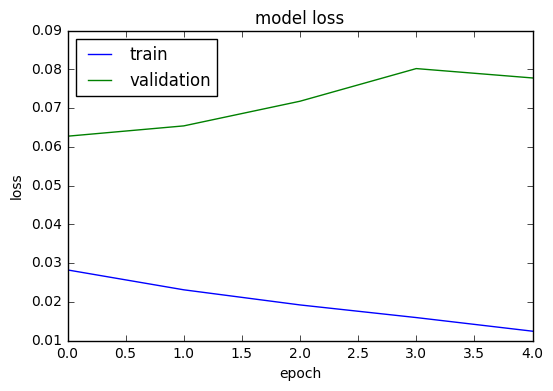

KeyError: 'activation_1_acc'

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['activation_1_acc'])
plt.plot(history.history['val_activation_1_acc'])
plt.title('model accuracy 15')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['activation_2_acc'])
plt.plot(history.history['val_activation_2_acc'])
plt.title('model accuracy 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['activation_3_acc'])
plt.plot(history.history['val_activation_3_acc'])
plt.title('model accuracy 3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Temporary

In [ ]:
from densenet import DenseNet, DenseNetImageNet121
dense = DenseNetImageNet121(input_shape=(360,640,3),weights='imagenet',include_top=False)

In [ ]:
model = Model(inputs = dense.input, outputs = dense.layers[-18].output)
model.summary()

In [ ]:
def createDenseNetFeatures(path,name):
    rgb_hires = load_array(path + name + '_hires.dat')
    conv_feat = model.predict(rgb_hires, batch_size=32, verbose=0)
    save_array('/cat/home/ubuntu/cat/out/features/train/'+name+'_dnsnt.dat',conv_feat)
    del(conv_feat,rgb_hires)
    gc.collect()

In [ ]:
files = ['trainfold1','trainfold2','trainfold3','trainfold4','trainfold5',
         'trainfold6','trainfold7','trainfold8','trainfold9','trainfold0'] 

for i in tqdm(range(len(files))):
    createDenseNetFeatures('/cat/home/ubuntu/cat/in/train/folds/',files[i])

# Evaluate

In [29]:
lrg_model.load_weights('/cat/home/ubuntu/cat/out/weights/sqznt_weights_folds_8_9_128_Iteration10.hdf5')

In [ ]:
frame=155
pred = lrg_model.predict(np.expand_dims(conv_val_feat[frame],0))
pred = np.hstack((pred[0],pred[1],pred[2]))
pred.shape
np.round(pred[0],4)

 0,5,6,9,10,11,12,13,14,15,16,17,18,19,20,1,2,3,4,7,8

In [ ]:
labels_temp = np.copy(labels_val[:,2:23])
labels_temp[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] = labels_temp[:,[0,5,6,9,10,11,12,13,14,15,16,17,18,19,20,1,2,3,4,7,8]]
labels_temp[frame,0:21]

In [30]:
files = ['train03_val_minus_0p5','train04_val_minus_0p5','train10_val_minus_0p5','train18_val_minus_0p5',
         'train21_val_minus_0p5','train14_val_minus_0p5','train19_val_minus_0p5','train24_val_minus_0p5']
FIRST_TIME=True
for i in range(len(files)):
    conv_val_feat = load_array('/cat/home/ubuntu/cat/out/features/train/'+files[i]+'_sqznt.dat')
    labels_val = load_array('/cat/home/ubuntu/cat/in/train/labels/'+files[i]+'_labels.dat')
    if FIRST_TIME:
        predictions_all = lrg_model.predict(conv_val_feat) 
        predictions_all = np.hstack((predictions_all[0],predictions_all[1][:,0:4],predictions_all[2][:,0:2]))
        labels_all = labels_val
        FIRST_TIME = False
    else:
        temp = lrg_model.predict(conv_val_feat)
        temp = np.hstack((temp[0],temp[1][:,0:4],temp[2][:,0:2]))
        predictions_all = np.vstack((predictions_all,temp))
        labels_all = np.vstack((labels_all,labels_val))
    del(conv_val_feat,labels_val)
    gc.collect()
print predictions_all.shape, labels_all.shape

(28900, 21) (28900, 23)


In [31]:
labels_all = labels_all[:,2:23]
labels_all[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]] = labels_all[:,[0,5,6,9,10,11,12,13,14,15,16,17,18,19,20,1,2,3,4,7,8]]

# Write code to do Test Time Augmentation by taking 10 non-random patches

In [32]:
# Computing the area under the ROC curve
from sklearn.metrics import roc_curve, auc
from math import isnan

totalScore=0
count = 0

predictions_temp = np.copy(predictions_all)
truth_temp = np.copy(labels_all)

for j in range(21):   
    index = 0
    #remove rows with label = 0.5
    for i in range(labels_all.shape[0]):
        if labels_all[i,j] != 0.5:
            truth_temp[index,j]=labels_all[i,j]
            predictions_temp[index,j]=predictions_all[i,j]
            index += 1
    fpr, tpr, _ = roc_curve(truth_temp[0:index,j], predictions_temp[0:index,j])
    score = auc(fpr, tpr)
    print j, score
    if isnan(score):
        score=0.0
    else:
        totalScore+=score
        count +=1
    
print totalScore/count

0 0.497888835052
1 0.949548121687
2 0.995430544234
3 0.485128756854
4 0.999702267613
5 0.955531330181
6 0.984763388126
7 0.996314836684
8 0.937283389651
9 0.943551282563
10 0.971013999751
11 0.926554614044
12 0.603605573328
13 0.499896067902
14 0.723801280942


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:538: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


15 nan
16 0.904718184235
17 0.923579599281
18 0.891071262348
19 0.919400295589
20 0.972723613317
0.854075362169



  train21 ; 0.957 

  train22 ; 0.972

  train23 ; 0.993

  train24 ; 0.924

  train25 ; 0.865

train21-5 ; 0.899


In [ ]:
del(conv_val_feat)
gc.collect()

# Visualize

In [ ]:
rgb_hires = load_array('/cataract/home/ubuntu/cataract/03_output/train21_rgb_hires.dat')
rgb_hires.shape

In [ ]:
labels = load_array('/cataract/home/ubuntu/cataract/03_output/train21_labels.dat')
labels[500,...]

In [ ]:
conv_trn_feat = load_array('/cataract4/home/ubuntu/cataract4/03_output/train21_fcf_feat.dat')

In [ ]:
labels.shape,conv_trn_feat.shape,rgb_hires.shape

In [ ]:
#load weights
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [ ]:
frame=500
inp = np.expand_dims(conv_trn_feat[frame], 0)
conv = conv_fn([inp,0])[0,:,:,0]
#conv = conv_fn([inp,0])
conv.shape

In [ ]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0,:,:,label]
    return scipy.misc.imresize(conv, (360,640))

In [ ]:
def plotImages(frame):
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['red', 'brown', 'yellow', 'green', 'blue']
    cmap = LinearSegmentedColormap.from_list('name', colors)
    norm = plt.Normalize(0, 254)
    inp = np.expand_dims(conv_trn_feat[frame], 0)
    index_array = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    f = plt.figure(figsize=(10, 40))
    r = len(index_array)

    A = np.transpose(rgb_hires,(0,2,3,1))[frame,]

    for k, i in enumerate(index_array):
        for j , M in enumerate([A,A,A]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if j==0:
                plt.imshow(M)
            else:
                if j==1:
                    plt.imshow(get_cm2(inp, i), cmap='cool', norm=norm, interpolation='none') 
                else:
                    plt.imshow(M)
                    plt.imshow(get_cm2(inp, i), cmap='cool', norm=norm, interpolation='none', alpha=0.5) 

256 convolutions filters

In [ ]:
plotImages(500)

In [ ]:
plotImages(1000)

In [ ]:
#plotImages(2000)

In [ ]:
#plotImages(3500)

In [ ]:
#plotImages(1500)

In [ ]:
labels[600,2:23]

In [ ]:
#plotImages(600)

128 convolution filters

In [ ]:
plotImages(100)

In [ ]:
plt.imshow(np.transpose(rgb_hires,(0,2,3,1))[1000,])

In [ ]:
cm = get_cm2(inp, 0)

In [ ]:
plt.imshow(cm, cmap="hot") # binary cross entropy with softmax

In [ ]:
gc.collect()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(rgb_hires,(0,2,3,1))[1000,])
plt.imshow(cm, cmap="hot", alpha=0.5) 

In [ ]:
cm = get_cm2(inp, 7)
plt.imshow(cm, cmap="gray") # binary cross entropy with softmax

In [ ]:
lr = [0.01,0.001,0.0001,0.00001]
e =[1,2,2,2]
p = [0.6]
tuneMyNw('fold_4','03_output/features',lr,e,p,get_lrg_layers,batch_size,allTags=True,base_model=None,early_stop=1)

In [ ]:
features, labels = loadFeatures('03_output/features','fold_4')
predictFolds('fold_4',get_bn_layers,'vgg',features,allTags=True,base_model='vgg')
np.savetxt('03_output/results/labels_vgg_fold_4.csv', labels, delimiter=",")

In [ ]:

tags = ['all']

learningSchedules = {}
learningSchedules['1'] = [0.01,0.001,0.0001]
learningSchedules['2'] = [0.01,0.001]
learningSchedules['3'] = [0.01]

epochSchedules = {}
epochSchedules['1'] = [1,2,4]
epochSchedules['2'] = [1,2]
epochSchedules['3'] = [1,2,3]
epochSchedules['4'] = [1,2,5]
epochSchedules['5'] = [1]
epochSchedules['6'] = [1,2,1]

dropouts = [0.8]
learningSchedule = ['1']
epochSchedule = ['1']

features, labels = loadFeatures('03_output/features','train')
trainFolds('test',tags,dropouts,learningSchedule,learningSchedules,epochSchedule,epochSchedules,
           get_bn_layers,'vgg',features, labels,batch_size,allTags=True,base_model='vgg')


In [ ]:
features, labels = loadFeatures('03_output/testfeatures', 'test')
predictFolds('test',get_bn_layers,'vgg',features,allTags=True,base_model='vgg')
np.savetxt('03_output/results/labels_vgg_test.csv', labels, delimiter=",")

# Scrapbook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,transform
%matplotlib inline

def data_aug(img = img):
	mu = 0
	sigma = 0.1
	feature_vec=np.matrix(evecs_mat)

	# 3 x 1 scaled eigenvalue matrix
	se = np.zeros((3,1))
	se[0][0] = np.random.normal(mu, sigma)*evals[0]
	se[1][0] = np.random.normal(mu, sigma)*evals[1]
	se[2][0] = np.random.normal(mu, sigma)*evals[2]
	se = np.matrix(se)
	val = feature_vec*se

	# Parse through every pixel value.
	for i in xrange(img.shape[0]):
		for j in xrange(img.shape[1]):
			# Parse through every dimension.
			for k in xrange(img.shape[2]):
				img[i,j,k] = float(img[i,j,k]) + float(val[k])

imnames = ['n00.jpg','n01.jpg','n02.jpg','n03.jpg','n04.jpg','n05.jpg']
#load list of images
imlist = (io.imread_collection(imnames))

res = np.zeros(shape=(1,3))
for i in range(len(imlist)):
	# re-size all images to 256 x 256 x 3
	m=transform.resize(imlist[i],(256,256,3))
	# re-shape to make list of RGB vectors.
	arr=m.reshape((256*256),3)
	# consolidate RGB vectors of all images
	res = np.concatenate((res,arr),axis=0)
res = np.delete(res, (0), axis=0)

# subtracting the mean from each dimension
m = res.mean(axis = 0)
res = res - m

R = np.cov(res, rowvar=False)
print R

from numpy import linalg as LA
evals, evecs = LA.eigh(R)

idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
# sort eigenvectors according to same index

evals = evals[idx]
# select the first 3 eigenvectors (3 is desired dimension
# of rescaled data array)

evecs = evecs[:, :3]
# carry out the transformation on the data using eigenvectors
# and return the re-scaled data, eigenvalues, and eigenvectors
m = np.dot(evecs.T, res.T).T

# perturbing color in image[0]
# re-scaling from 0-1
img = imlist[0]/255.0
data_aug(img)
plt.imshow(img)

In [ ]:
labelFile = load_array('/cataract/home/ubuntu/cataract/03_output/train01_labels.dat')
features = load_array('/cataract2/home/ubuntu/cataract2/03_output/train01_fcf_feat.dat')

In [ ]:
lrg_model.fit(conv_trn_feat, labels[:,2:23], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels_val[:,2:23])) #binary cross entropy with sigmoid n = 256

In [ ]:
def auc_tool(truth_directory, prediction_directory, tool):
    """Computes the area under the ROC curve for one tool.
    """
    filename = ''
    try:
    truth = []
    predictions = []
    # loop on (truth, predictions) file pairs
    for file in range(1, num_files + 1):

    # getting the filenames
    if (file < 10):
    filename = file_prefix + '0{}.csv'.format(file)
    else:
    filename = file_prefix + '{}.csv'.format(file)
    truth_filename = join(truth_directory, filename)
    prediction_filename = join(prediction_directory, filename)
    # parsing the right column for the current tool
    truth_data = read_csv(truth_filename, header = 0, skipinitialspace = True,
    usecols = [tool], squeeze = True, dtype = 'float32').tolist()
    prediction_data = read_csv(prediction_filename, header = None, skipinitialspace = True,
    usecols = [tool], squeeze = True, dtype = 'float32').tolist()
    if len(truth_data) != len(prediction_data):
    raise ValueError('Files {} and {} have different row counts'.
    format(truth_filename, prediction_filename))

    # appending rows with consensual ground truth
    indices = [index for index, value in enumerate(truth_data) if value != 0.5]
    truth += [truth_data[index] for index in indices]
    predictions += [prediction_data[index] for index in indices]

    # computing the area under the ROC curve
    fpr, tpr, _ = roc_curve(truth, predictions)
    score = auc(fpr, tpr)
    return 0. if isnan(score) else score
    except Exception as e:
    print('Error: missing column in {} for tool number {}!'.format(filename, tool)
    if 'Usecols' in str(e) else 'Error: {}!'.format(e))
    return 0.


    def main():
    """Main function.
    """

    # parsing the command line
    parser = ArgumentParser(description = 'Evaluator for the CATARACTS challenge.')
    parser.add_argument('-t', '--truth', required = True, help = 'directory containing ground truth files')
    parser.add_argument('-p', '--predictions', required = True, help = 'directory containing automatic predictions')
    args = parser.parse_args()

    # computing tool-specific scores
    scores = []
    for tool in range(1, num_tools + 1):
    score = auc_tool(args.truth, args.predictions, tool)
    print('Score tool {0}: {1:.4f}'.format(tool, score))
    scores.append(score)

    # computing the average score
    print('Average: {0:.4f}'.format(sum(scores) / float(len(scores))))


In [ ]:
path='../03_output/'
name='train01'
rgb_hires = load_array(path + name + '_rgb_hires.dat')

In [ ]:
rgb_hires.shape

In [ ]:
conv_feat = vgg640.predict(rgb_hires[1:100], batch_size=32, verbose=1)

In [ ]:
rgb_hires = load_array('03_output/train01_rgb_hires.dat')
labels = load_array('03_output/train01_labels.dat')

In [ ]:
rgb_hires_val = load_array('03_output/train25_rgb_hires.dat')
labels_val = load_array('03_output/train25_labels.dat')

In [ ]:
rgb_hires_val.shape

In [ ]:
rgb_hires = np.reshape(np.transpose(rgb_hires,(1,0)),(2460,360,640,3)) 

In [ ]:
rgb_hires_val = np.reshape(np.transpose(rgb_hires_val,(1,0)),(6990,360,640,3)) 

In [ ]:
rgb_hires.shape, labels.shape,rgb_hires_val.shape, labels_val.shape

In [ ]:
rgb_hires = np.transpose(rgb_hires,(0,3,1,2)) 
rgb_hires_val = np.transpose(rgb_hires_val,(0,3,1,2))

In [ ]:
labels = np.transpose(labels,(1,0))
labels_val = np.transpose(labels_val,(1,0))

In [ ]:
labels.shape

In [ ]:
rgb_hires.shape
plt.imshow(rgb_hires[0])

In [ ]:
conv_trn_feat = vgg640.predict(rgb_hires_val, batch_size=32, verbose=1)
conv_val_feat = vgg640.predict(rgb_hires, batch_size=32, verbose=1)

In [ ]:
save_array('03_output/train25_fcn_feat.dat',conv_trn_feat)
save_array('03_output/train01_fcn_feat.dat',conv_val_feat)

In [ ]:
conv_layers,_ = split_at(vgg640, Convolution2D)

In [ ]:
nf=128; p=0.0

In [ ]:
nf=256; p=0.2

In [ ]:
nf=256; p=0.2
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(21,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [ ]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(21,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ]

In [ ]:
lrg_model = Sequential(get_lrg_layers())

In [ ]:
lrg_model.summary()

In [ ]:
lrg_model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 64

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid n = 256

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid n = 128

In [ ]:
lrg_model.optimizer.lr=1e-5

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #categorical cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid  n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 256

In [ ]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [ ]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [ ]:
inp = np.expand_dims(conv_val_feat[400], 0)

In [ ]:
plt.imshow(to_plot(rgb_hires[400]))

In [ ]:
cm = get_cm2(inp, 0)

In [ ]:
plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="cool", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="cool", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
cm = get_cm2(inp, 2)

In [ ]:
plt.imshow(cm, cmap="gray") # binary cross entropy with softmax n = 256

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="gray", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
labels[400]

In [ ]:
files = ['train02','train03','train04','train05','train06','train07','train08','train09','train10','train11',
         'train12','train13','train14','train15','train16','train17','train18','train19','train20','train21','train22',
         'train23','train24','train25'] 

labels = load_array('../03_output/train01_labels.dat')
for i in tqdm(range(len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    labels = np.vstack((labels,lbl))
    del(lbl)
    gc.collect()
labels.shape

In [ ]:
anyLabel = sum(np.transpose(labels)[3:23,:])
unique, counts = np.unique(anyLabel, return_counts=True)
unique, counts

In [ ]:
labels[labels==0.5]=999
anyLabel = sum(np.transpose(labels)[3:23,:])
unique, counts = np.unique(anyLabel, return_counts=True)
unique, counts

In [ ]:
'0',36060/82479.0,'1',13838/82479.0,'2',30591/82479.0,'0.5 or 1.5 or 2.5 or 3', (1595+334+27+34)/82479.0

In [ ]:
anyLabel.shape

In [ ]:
from scipy.ndimage.interpolation import shift

lagggedLabels = shift(anyLabel, -15, cval=1)
lagggedLabels[lagggedLabels<0.5]=0
for i in range(30):
    temp = shift(anyLabel, -14+i, cval=1)
    temp[temp<0.5]=0
    lagggedLabels = np.vstack((lagggedLabels,temp))

lagggedLabels.shape
anyLabelLag15 = sum(lagggedLabels)
anyLabelLag15.shape
anyLabelLag15[anyLabelLag15>0]=1
unique, counts = np.unique(anyLabelLag15, return_counts=True)
unique, counts
keepOrNot = np.vstack((anyLabel,anyLabelLag15)).T
keepOrNot.shape

In [ ]:
unique, counts = np.unique(keepOrNot[:,0], return_counts=True)
unique, counts